# 1. 介绍

深度学习的预测结果的效果，是需要一个评估标准的。在分类中，可以用分类准确率。而图像识别的的评估标准，识别的准确率等等也是很重要的指标，下面我们将对之前进行的预测结果进行评估，看看数字化的指标是怎么样的，而不是用眼睛去评价一个网络的性能。

更进一步的，不仅仅是要评估网络性能，更要评估超参数对网络的影响，从而筛选出最好的超参数。

In [98]:
import os
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from dataset import voc
from retinanet import model, val
from retinanet import transforms as aug
%matplotlib inline

# 2. 初始化
## 2.1 设定常量
初始化的内容和前面是完全一样的，这样可以保证我们的关键参数更容易修改，即使跨越了好几份代码。

In [72]:
root_path = './data'
img_path = "./data/JPEGImages"
result_path = './result'
model_name = "root_treatment"

image_size=512
max_detections = 4
num_classes = 2

## 2.2 加载模型和数据
我们依然需要加载模型，这是因为在本课中，我们会多次修改超参数来进行预测，分别评判各个超参数的效果。

In [99]:
val_trans = aug.Compose([
    aug.Pad(),
    aug.Resize(image_size, image_size),
    aug.AutoLevel(min_level_rate=1, max_level_rate=1),
    aug.AutoContrast(),
    aug.Contrast(1.25),
    aug.ToTensor()
])

val_set = voc.VOCDetection(
    root_path,
    image_set="val_list",
    transforms=val_trans
)

retinanet = torch.load(os.path.join(result_path, model_name +".pth", map_location='cpu'))
device = torch.device("cpu")
retinanet = retinanet.to(device)

## 2.3 预测的准备

同样的预测，只是调整几个不同的参数，这就需要我们将整个流程抽象出来，加以复用。下面是几个关键的函数，他们组成了预测和评估的全过程。

我们先介绍这几个参数，随后我们将针对这几个参数来设计程序。他们分别是：
1. nms：衡量了预测的密集程度。网络会尽量地去预测标注框，而这些框全部标注出来的话，对同一个目标会有多个框，肉眼看上去会非常密集，控制这个参数可以删除过于密集的框，整个图像显得清楚很多。
2. detection_scale：预测出来的框会比真实的框普遍偏大，这是因为训练的时候对图像进行了很多变换，导致标注框变大，被网络学习到了，预测的时候也会偏大一些。控制这个变量，可以将标注框缩小一些。
3. score_threshold：每个框被预测出来的时候，网络都会有确信的程度，表现了网络对预测的自信程度，这时候我们将自信程度低的全部删除，以提高预测出来的框的准确率。控制这个变量，以筛选自信程度的门槛。
4. iou_threshold：每个预测框和真实框的重叠程度，重叠率越高则表示预测效果越好。

接下来，我们开始进入程序。

首先依然是预测函数。基本上和第一课相同，有一些不一样的地方，将在程序中以备注形式标注出来。

In [74]:
def _get_detections(dataset, retinanet, nms=None, detection_scale=None, num_classes=2, score_threshold=0.5, max_detections=100, save_path=None, model_name=None):
    
    all_detections = [[None for i in range(num_classes)] for j in range(len(dataset))]
    retinanet.eval()
    
    # 对比第一课，这里并没有nms的设置，而是将其变成了一个参数，可以进行控制
    if nms:
        retinanet.set_nms(nms)
        
    with torch.no_grad():

        for index in range(len(dataset)):
            data = dataset[index]
            # data is a tuple: (img, ([labels], [gts], {scale, pad_loc...}))
            scale = data[1][2]["scale"]
            # get pad loc, up, down, left, right
            pad_loc = data[1][2]["pad_loc"]

            # run network
            scores, labels, boxes = retinanet(data[0].permute(0, 1, 2).to(device).float().unsqueeze(dim=0))
            scores = scores.cpu().numpy()
            labels = labels.cpu().numpy()
            boxes  = boxes.cpu().numpy()
            
            # 这里按照detection_scale对预测框进行缩放
            if detection_scale:
                for bbx in boxes:
                    center_x = (bbx[0] + bbx[2]) / 2
                    center_y = (bbx[1] + bbx[3]) / 2
                    new_width = (bbx[2] - bbx[0]) * detection_scale
                    new_height = (bbx[3] - bbx[1]) * detection_scale
                    bbx[0] = center_x - ( new_width / 2 )
                    bbx[2] = center_x + ( new_width / 2 )
                    bbx[1] = center_y - ( new_height /2 )
                    bbx[3] = center_y + ( new_height /2 )
            
            # 下面被注释的代码，是由于模型需要用512的图像进行预测，所以这里我们为了得到原图，进行了一些反变换
            # 但是，在这个优化阶段不能化成原图，因为要用统一的标准来衡量不同的预测效果，所以全部图都保持512的大小
#             boxes /= scale
#             for bbx in boxes:
#                 # height fix
#                 bbx[1] -= pad_loc[0]
#                 bbx[3] -= pad_loc[0]
#                 # width fix
#                 bbx[0] -= pad_loc[2]
#                 bbx[2] -= pad_loc[2]
            
            # 这里控制筛选scores > score_threshold的标注框
            indices = np.where(scores > score_threshold)[0]
            if indices.shape[0] > 0:
                # select those scores
                scores = scores[indices]

                # find the order with which to sort the scores
                scores_sort = np.argsort(-scores)[:max_detections]

                # select detections
                image_boxes      = boxes[indices[scores_sort], :]
                image_scores     = scores[scores_sort]
                image_labels     = labels[indices[scores_sort]]
                image_detections = np.concatenate([image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_labels, axis=1)], axis=1)
                
                # copy detections to all_detections
                for label in range(num_classes):
                    all_detections[index][label] = image_detections[image_detections[:, -1] == label, :-1]
            else:
                # copy detections to all_detections
                for label in range(num_classes):
                    all_detections[index][label] = np.zeros((0, 5))
            
            print("\r {}/{}".format(index + 1, len(dataset)), end='')
    
    # 将结果保存到save_path下的csv中，为了区分不同的csv，我们将传入的参数作为csv的名字的一部分
    if save_path:
        csv_data = pd.DataFrame(columns=['id', 'serial', 'class', 'score', 'x1', 'y1', 'x2', 'y2', 'prob'])
        csv_id = 0
        for index in range(len(all_detections)):
            image_name = dataset.images[index].split('/')[-1].split('.')[0]
            for label in range(len(all_detections[index])):
                for box in range(len(all_detections[index][label])):
                    bbx = all_detections[index][label][box]
                    csv_data.loc[csv_id] = [image_name, box, label, 0, bbx[0], bbx[1], bbx[2], bbx[3], bbx[4]]
                    csv_id += 1
                    
        file_name = "{}_{}".format(
            model_name,
            score_threshold,
        )
        if nms:
            file_name = file_name + "_" + str(nms)
        if detection_scale:
            file_name = file_name + "_" + str(detection_scale)
        
        print("\nsave to ", save_path, file_name + ".csv")
        csv_data.to_csv(os.path.join(save_path, file_name+".csv"))
    
    return all_detections

我们的已知标注的格式并不是我们需要的格式，因而在这里从数据集中取出数据，并组装成我们想要的样子。

即从`(img, ([labels], [gts], {scale, pad_loc...}))` 格式，转换到 `all_annotations[index][label][x1, y1, x2, y2, prob]` 的格式。

In [75]:
def _get_annotations(generator, num_classes):
    all_annotations = [[None for i in range(num_classes)] for j in range(len(generator))]
    
    for index in range(len(generator)):
        # load the annotations, annotations is a tuple: (img, ([labels], [gts], {scale, pad_loc...}))
        annotations = generator[index][1]
        labels = annotations[0].numpy()
        boxes = annotations[1].numpy()
        
        for label in range(num_classes):
            if label in labels:
                id_list = np.where(labels == label)[0]
                all_annotations[index][label] = boxes[id_list]
            else:
                all_annotations[index][label] = np.zeros((0, 5))

    return all_annotations

\_compute_ap 可以通过传入的 recall 以及 precision 计算出 average precision， 这个算法这里不多做介绍。

compute_overlap 可以计算出两个图中框的重合度，并返回一个元素为不同的框重合度的list。

In [76]:
def _compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def compute_overlap(a, b):
    """
    Parameters
    ----------
    a: (N, 4) ndarray of float
    b: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua

下面的函数是这次的关键函数，他负责收集全部参数，并传递给\_get_detections和\_get_annotations，获取了全部的预测和原有标注后，将计算出全部框的总的average_precisions, recall, 和precision，并且将所有预测表现很差的框的id记下来，后面可以看到为什么他们表现很差。

这里解释一下recall和precision。

如果某个对象应该被预测出来，并且他确实被预测出来了，那么他叫做true positive，意为正确的预测。

如果某个对象不应该被预测出来，但是他被预测出来了，那么他叫做false positive。意为错误的预测。

recall = true positive / 应该被预测出来的总量，意为在全部应该被预测出来的标注中，成功被预测的部分的占比。recall高的时候，网络更不会放过有嫌疑的对象。

precision = true positive / true positive + false positive，意为被预测出来的框中，成功被预测的部分的占比。precision高的时候，网络对对象的预测结果通常会很准确。

这两个参数并不矛盾，但是通常情况下，在都比较低的时候，两者随着网络的性能增长而同时增长，而即将达到瓶颈的时候，很难兼顾。

In [77]:
def evaluate(generator, retinanet, nms=None, iou_threshold=0.5, detection_scale=None, num_classes=2, score_threshold=0.9, max_detections=4, save_path=None, model_name=None):
    # 获得全部的 detections and annotations
    all_detections     = _get_detections(generator, retinanet, nms=nms, detection_scale=detection_scale, num_classes=num_classes, score_threshold=score_threshold, max_detections=max_detections, save_path=save_path, model_name=model_name)
    all_annotations    = _get_annotations(generator, num_classes=num_classes)
    
    # 准备好储存结果的数据结构，都是这个格式 {0: , 1: }
    detect_amount = {}
    average_precisions = {}
    final_recall = {}
    final_precision = {}
    image_lists = {}
    
    # 按照 label 对目标进行迭代
    for label in range(num_classes):
        false_positives = np.zeros((0,))
        true_positives  = np.zeros((0,))
        scores          = np.zeros((0,))
        num_annotations = 0.0
        num_detections = 0.0
        image_list = []
        
        # 按照图像顺序对目标进行迭代
        for i in range(len(generator)):
            detections           = all_detections[i][label]
            annotations          = all_annotations[i][label]
            num_annotations     += annotations.shape[0]
            detected_annotations = []
            
            # 如果有预测结果，我们增加 num_detections，即总预测数量
            if detections.shape[0] > 0:
                num_detections += detections.shape[0]
            else:
                continue
            
            # 标志某图像的预测结果好坏
            bad_flag = False
            
            # 对一张图中的全部预测结果进行迭代评估
            for d in detections:
                # detection[4] 就是网络的自信程度
                scores = np.append(scores, d[4])
                
                # 如果原图都没有框，而预测出来了，则 fp + 1, tp + 0
                if annotations.shape[0] == 0:
                    false_positives = np.append(false_positives, 1)
                    true_positives  = np.append(true_positives, 0)
                    continue
                
                # d 是预测的每一个box, overlaps是覆盖率的list
                overlaps            = compute_overlap(np.expand_dims(d, axis=0), annotations)
                # 覆盖率最大的下标
                assigned_annotation = np.argmax(overlaps, axis=1)
                # 最大覆盖率
                max_overlap         = overlaps[0, assigned_annotation]
                
                # 当最大覆盖率都达不到重叠标准，则将这个图记住
                if max_overlap < iou_threshold:
                    bad_flag = True
            
                # 如果覆盖率大于iou_threshold，则 tp + 1， fp + 0，否则反之
                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives = np.append(false_positives, 0)
                    true_positives  = np.append(true_positives, 1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives = np.append(false_positives, 1)
                    true_positives  = np.append(true_positives, 0)
            
            # 将图像id加入名单
            if bad_flag:
                image_list.append(i)
            
        # 如果本来都没有标注，则将 average_precisions 设为 0？
        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue
        
        # 下面是对recall，precision 和 average_precision 进行计算
        indices         = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives  = true_positives[indices]
        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives  = np.cumsum(true_positives)

        # recall和precision是经过排序的list，代表了单调的曲线，从而积分计算 average_precision
        recall    = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        average_precision  = _compute_ap(recall, precision)
        
        # 将我们需要的数据存起来
        detect_amount[label] = num_detections
        average_precisions[label] = average_precision
        final_recall[label] = recall[-1]
        final_precision[label] = precision[-1]
        image_lists[label] = image_list
    
    return detect_amount, average_precisions, final_recall, final_precision, image_lists

初始化各项参数，下面的代码都不会修改这些初始参数。

In [78]:
# optimize initialize
iou_threshold = 0.3
score_threshold = 0.5
nms = 0.7 
detection_scale = 1

# 3 开始预测
## 3.1 选择优化对象

我们的目的不仅仅是预测，还有对参数的优化，即所谓的参数的调优，使得模型的预测效果达到最佳。score， nms， detection_scale，iou的最好选择区间已经标出。

基于数次实验，有以下结论：
1. score取值[0.5, 0.6]
2. nms 取值[0.65, 0.7]
3. detection_scale取值 [0.7, 1] 取值并无太大关系
4. iou取值 [0.2, 0.3] 取值并无太大关系

我们已经将这些备用的list放在了程序中。这里我们选择每次优化一个参数，将其备选的值做成一个list，然后迭代每个值，输出其预测效果。这个预测效果必须由人来决定好坏，所以我们很难用程序来自动地进行调优。

In [167]:
score_threshold_list = [ x / 100 for x in range(0, 100) if x % 5 == 0]
nms_list = [ x / 100 for x in range(60, 75) if x % 5 == 0]
detection_scale_list = [ x / 100 for x in range(70, 100) if x % 5 == 0]
iou_threshold_list = [ x / 10 for x in range(2, 6)]

# 在这里选择你想要优化的参数
optimize_object_list = score_threshold_list
optimize_object_list

[0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

optimize_object_list 就是我们要选择的调试对象。将其赋值为由列表生成式生成的list，就可以直接在后面使用了。

然后后准备好储存结果的数据结构。

In [168]:
label_zero = pd.DataFrame(np.arange(len(optimize_object_list) * 4).reshape((len(optimize_object_list),4)), index=optimize_object_list,columns=['detect_amount','average_precisions','recall','precision']) 
label_one  = label_zero.copy()
image_lists = {0:{}, 1:{}}


下面的循环将遍历我们的optimize_object_list，每一次都保存其结果，供我们评判。需要注意的是，这里需要将传入的参数名进行修改，想对哪个参数进行调优，就修改其传入的参数为optimize_object，其余的参数都在上面已经赋值好了。

我们这里为了演示效果，只对 label 0，即根管的预测结果进行了结果的储存。

In [169]:
# time
for optimize_object in optimize_object_list:
    print(optimize_object)
    result = evaluate(val_set, 
              retinanet, 
              # replace the target variable you want optimize
              nms=optimize_object,
              score_threshold=score_threshold,
              detection_scale=detection_scale,
              iou_threshold=iou_threshold, 
              ###############################################
              num_classes=num_classes, 
              max_detections=max_detections, 
              save_path=result_path,
              model_name=model_name
             )
    # result[index][label], but infact we dont care label 1
    label_zero.loc[optimize_object] = [result[0][0], result[1][0], result[2][0], result[3][0]]
    # label_one.loc[optimize_object] = [result[0][1], result[1][1], result[2][1], result[3][1]]
    image_lists[0][optimize_object] = result[4][0]
    # image_lists[1][optimize_object] = result[4][1]


0.0
 49/49
save to  ./result root_treatment_0.5_1.csv
0.05
 49/49
save to  ./result root_treatment_0.5_0.05_1.csv
0.1
 49/49
save to  ./result root_treatment_0.5_0.1_1.csv
0.15
 49/49
save to  ./result root_treatment_0.5_0.15_1.csv
0.2
 49/49
save to  ./result root_treatment_0.5_0.2_1.csv
0.25
 49/49
save to  ./result root_treatment_0.5_0.25_1.csv
0.3
 49/49
save to  ./result root_treatment_0.5_0.3_1.csv
0.35
 49/49
save to  ./result root_treatment_0.5_0.35_1.csv
0.4
 49/49
save to  ./result root_treatment_0.5_0.4_1.csv
0.45
 49/49
save to  ./result root_treatment_0.5_0.45_1.csv
0.5
 49/49
save to  ./result root_treatment_0.5_0.5_1.csv
0.55
 49/49
save to  ./result root_treatment_0.5_0.55_1.csv
0.6
 49/49
save to  ./result root_treatment_0.5_0.6_1.csv
0.65
 49/49
save to  ./result root_treatment_0.5_0.65_1.csv
0.7
 49/49
save to  ./result root_treatment_0.5_0.7_1.csv
0.75
 49/49
save to  ./result root_treatment_0.5_0.75_1.csv
0.8
 49/49
save to  ./result root_treatment_0.5_0.8_1.csv
0.

我们可以输出label_zero这个dataframe看看结果是如何的。可以看见他是一个表格形态，最左边的index是想优化的对象，列名分别是预测出来的框数，average_precisions，recall和precision。

其中，average_precisions，recall和precision都是越高越好。但有时候不能两全的时候，我们需要凭借自身的经验来进行取舍。

In [171]:
label_zero

detect_amount  average_precisions    recall  precision
0.00           43.0            0.799642  0.807692   0.976744
0.05            8.0            0.153846  0.153846   1.000000
0.10            8.0            0.153846  0.153846   1.000000
0.15            8.0            0.153846  0.153846   1.000000
0.20            8.0            0.153846  0.153846   1.000000
0.25            8.0            0.153846  0.153846   1.000000
0.30            8.0            0.153846  0.153846   1.000000
0.35            9.0            0.173077  0.173077   1.000000
0.40            9.0            0.173077  0.173077   1.000000
0.45           17.0            0.294118  0.307692   0.941176
0.50           26.0            0.471154  0.480769   0.961538
0.55           36.0            0.662927  0.673077   0.972222
0.60           43.0            0.799642  0.807692   0.976744
0.65           44.0            0.820367  0.826923   0.977273
0.70           46.0            0.839316  0.846154   0.956522
0.75           55.0            0.913662  0.923077   0.872727
0.80           64.0            0.911245  0.923077   0.750000
0.85           77.0            0.882340  0.923077   0.623377
0.90           97.0            0.774775  0.903846   0.484536
0.95           75.0            0.584547  0.788462   0.546667

In [172]:
# todo: draw plot


我们可以看看预测效果很差的图像有哪些。当一张图中的全部框的覆盖率都很高的时候，这个list可能是空的。通常，precision越高，list中图像越少。

In [69]:
image_lists[0]

{0.6: [], 0.65: [], 0.7: [], 0.75: [], 0.8: [], 0.85: [], 0.9: [], 0.95: []}

# 4. 结果可视化
这些冷冰冰的数字对于机器来说很棒，但是对于人来说就可能摸不着头脑。这时候我们需要将结果画出来，看看到底怎么样。

下面是我们的作画函数，我们并没有保证图像都是原尺寸，因为没有必要。我们要看的是两个框的重叠程度。传入数据集和代表预测结果的dataframe，image_list是选择显示的图像的序号列表，以及图片储存的路径img_path，就可以画出全部的图像，最后两个参数是控制两者的颜色。

In [45]:
# draw boxes on images 
def draw_both_box(data_set, img_pd, image_list, img_path=None, origin_color=[0, 0, 255], detection_color=[0, 255, 0]):
    # img_list 格式是 [id1, id2...]
    for image_id in image_list:
        # 获取图像名称
        image_name = data_set.images[image_id].split('/')[-1].split('.')[0]
        
        # 将图像转化成numpy的array格式，注意其三个维度代表了什么，这里三个维度的顺序应该是height，width，channel
        np_img = data_set[image_id][0].numpy()
        np_img = np.transpose(np_img, (1, 2, 0))
        
        # 取出原始的标注，这里的标注已经经过了变换，使得其适应512尺寸的图像。然后画在图像上。
        anno = data_set[image_id][1]
        classes = anno[0].numpy()
        gts = anno[1].numpy()
        
        # get class 0, 副作用：算覆盖率的时候筛出来的错误框可能并不显示在图像上，当你需要显示两种label的时候，注释掉下面这一行
        gts = gts[np.where(classes == 0)[0]]
        
        # bbs是一个list，里面的每个元素都代表了一个框
        bbs = []
        for gt in gts:
            bbs.append(BoundingBox(x1=gt[0], y1=gt[1], x2=gt[2], y2=gt[3]))

        bbs_on_img = BoundingBoxesOnImage(bbs, shape=np_img.shape)
        
        # 用draw_on_image方法将框画在图像上，并返回这个新的图像
        draw_img = bbs_on_img.draw_on_image(np_img, size=2, color=origin_color)
        
        # 下面将在这个图像的基础上，再画出预测框。首先筛选出图像名字是 image_name 的部分框
        img_some = img_pd[img_pd['id'] == image_name]
        # get class 0
        img_some = img_some[img_some['class'] == 0]
        
        # dataframe 是一行一框，而一张图有可能有多个预测框
        for index in range(img_some.shape[0]):
            img_detect = img_some.iloc[index]
            x1 = img_detect['x1']
            y1 = img_detect['y1']
            x2 = img_detect['x2']
            y2 = img_detect['y2']
            
            # 和上面的画法是一行的
            bbs = []
            bbs.append(BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2))
            bbs_on_img = BoundingBoxesOnImage(bbs, shape=np_img.shape)
            draw_img = bbs_on_img.draw_on_image(draw_img, size=2, color=detection_color)
            
            # 计算每个预测框的覆盖率，看看为什么他们被认为是成功预测，或者失败预测
            d = np.array([x1, y1, x2, y2, img_detect['prob']])
            if len(gts) > 0:
                overlaps            = compute_overlap(np.expand_dims(d, axis=0), gts)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap         = overlaps[0, assigned_annotation]
                print(max_overlap)
        
        # 将最终的图像画出来
        ia.imshow(draw_img)

## 4.1 加载数据

我们之气那是将所有的预测结果都保存到了本地的，现在只需要读取就可以了。

注意读取的csv的名字问题。

In [66]:
score_threshold = 0.7
nms = 0.6 
detection_scale = 1
detection = "{}_{}_{}_{}.csv".format(
            model_name,
            score_threshold,
            nms,
            detection_scale
        )
img_pd = pd.read_csv(os.path.join(result_path, detection), index_col=0)

下面将画出在对比中表现差的图像，即false_positive，或者是表现好的图像，true_positive。

这里需要手动调整从image_lists取出的内容。image_lists的结构是`{0：{0.5：[], 0.6: [], 0.9: []}，1：{}}`，这里面的数字就是之前的optimize_object_list的元素，他们对应了各自的预测失败的结果。

In [67]:
image_list = image_lists[0][score_threshold]

false_positive = image_list
true_positive = []
for i in range(len(val_set.images)):
    if i not in image_list:
        true_positive.append(i)

image_list = true_positive

下面就可以正式画出结果了，初始设置预测为绿色，原始标注为蓝色。可以看出预测效果还是非常不错的。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.90155138]


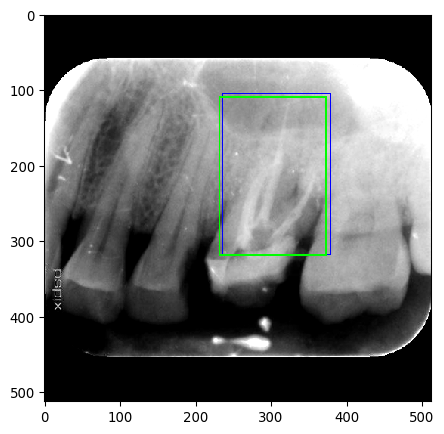

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


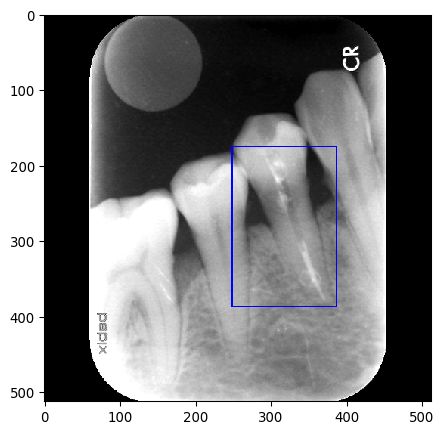

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.91816375]


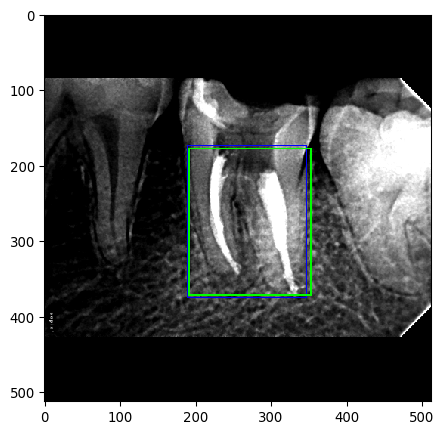

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.68295297]
[0.58065619]


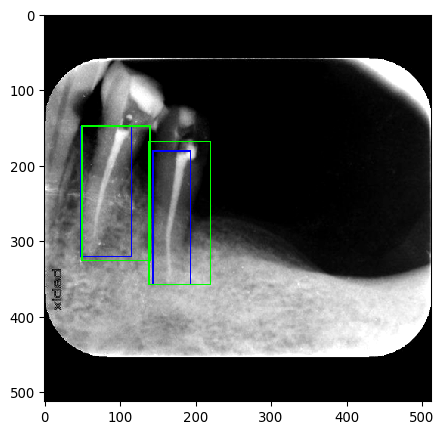

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.86747171]


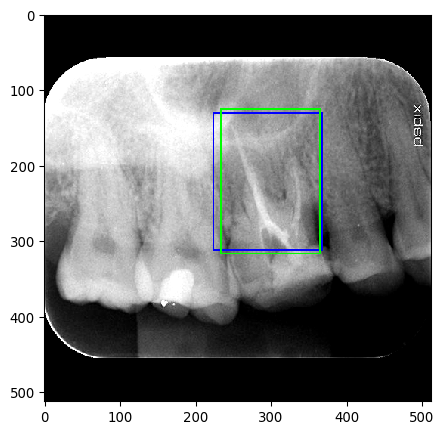

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


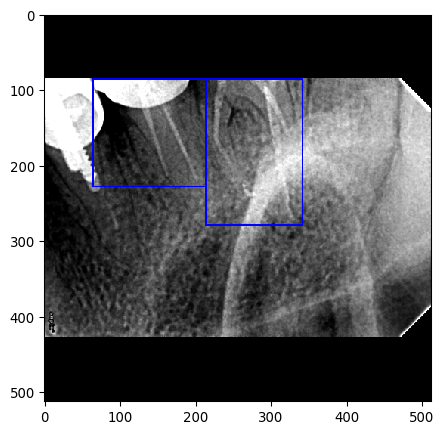

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.91633306]


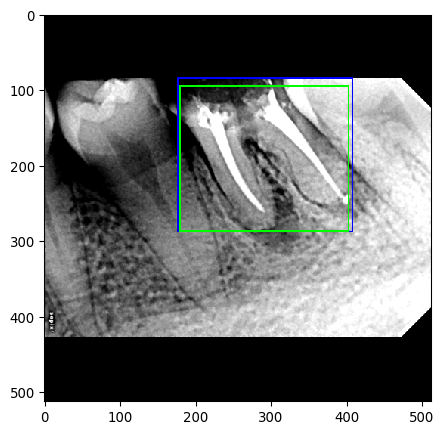

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.76010448]


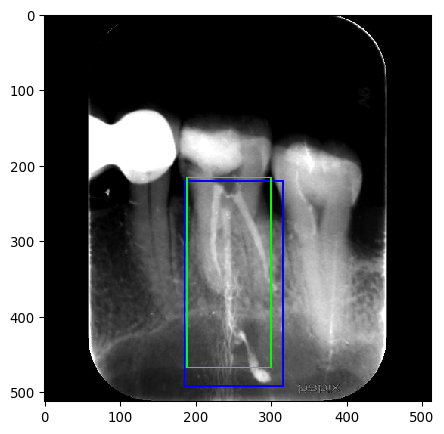

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.91074031]


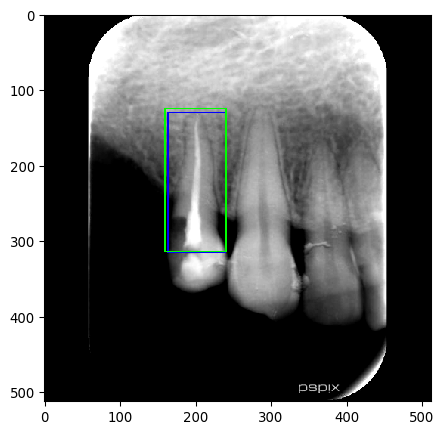

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


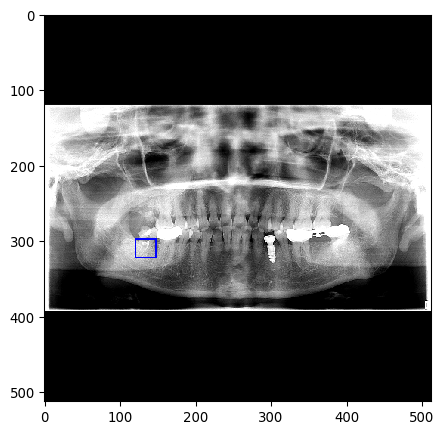

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.66989776]


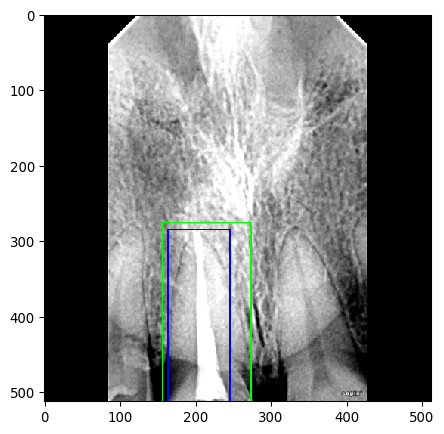

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.91892047]


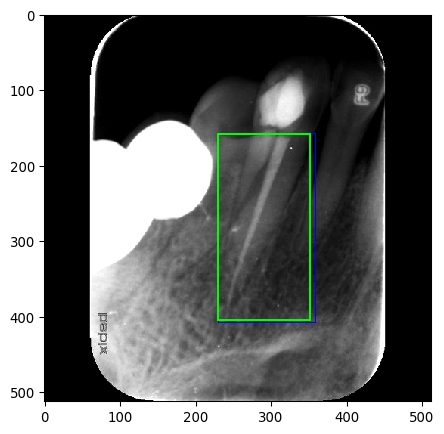

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.92197357]


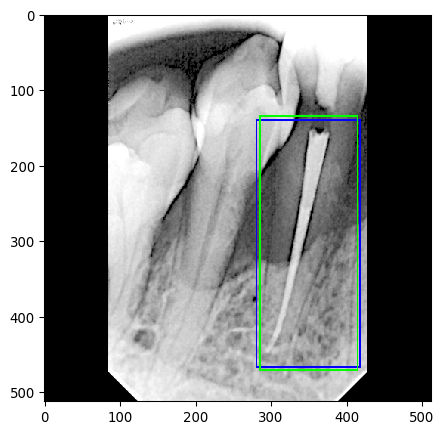

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.93356506]


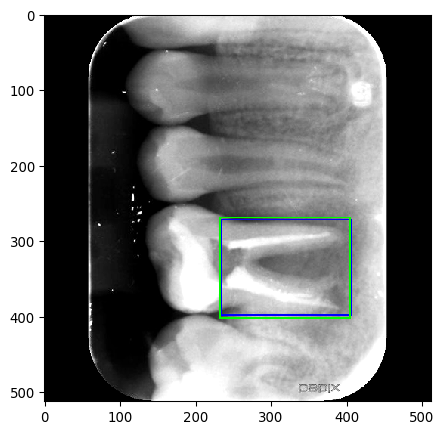

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


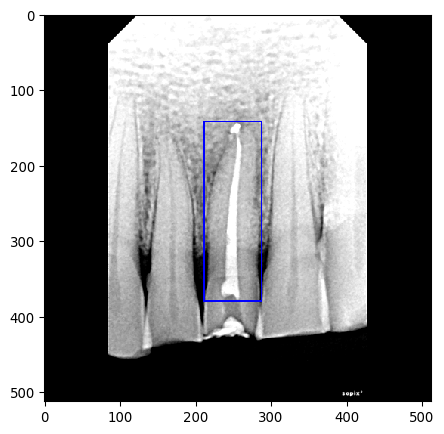

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.80522062]


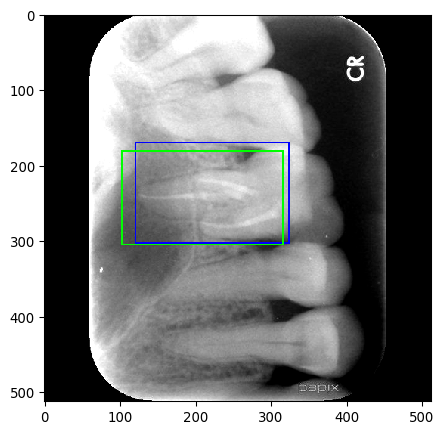

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.967637]


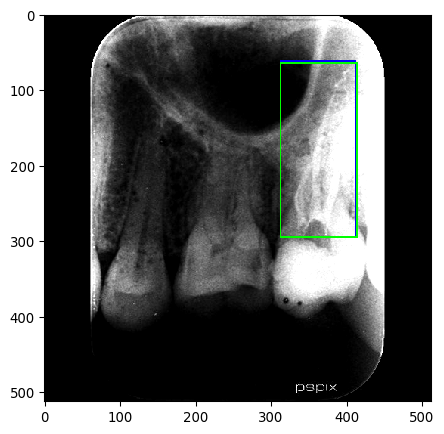

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.93858479]


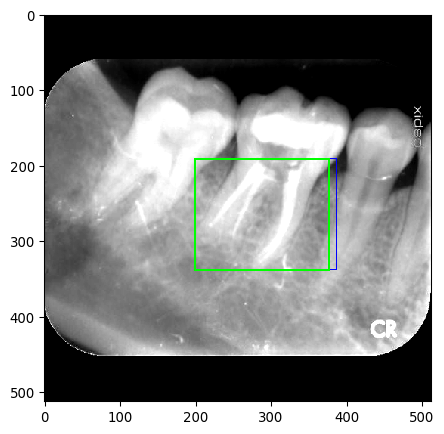

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.8847758]


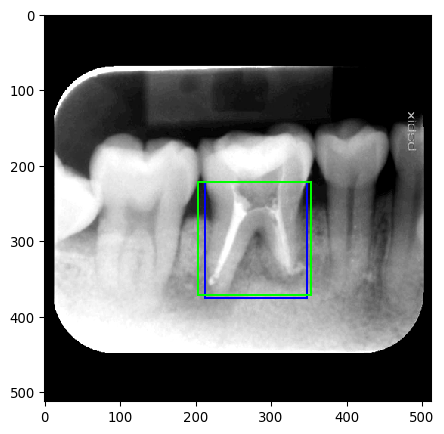

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.88212332]


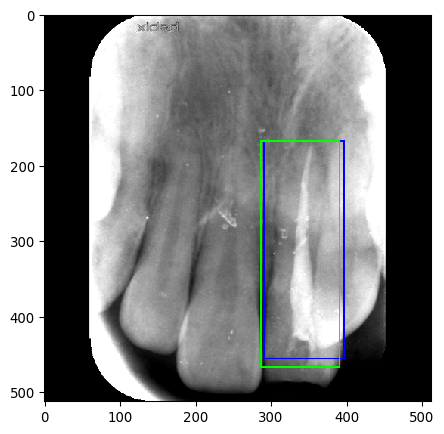

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.90028682]


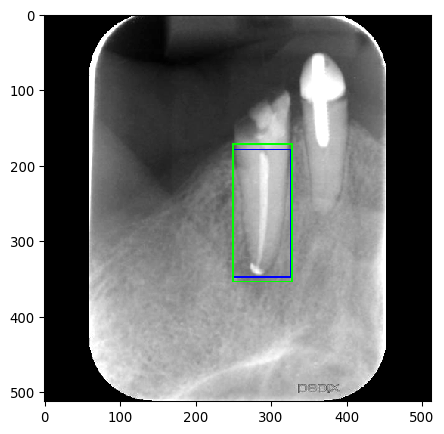

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.91192204]


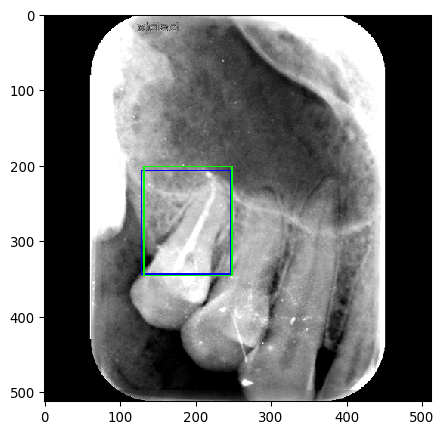

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.96292925]


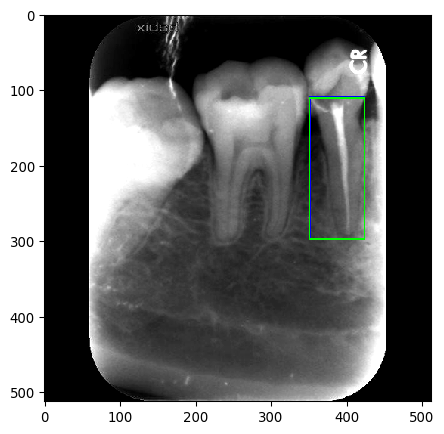

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.72529559]


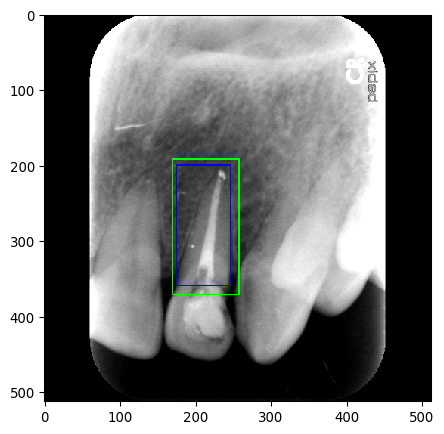

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.9282302]


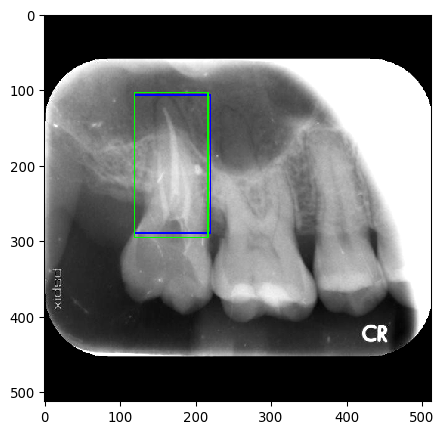

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.84149428]


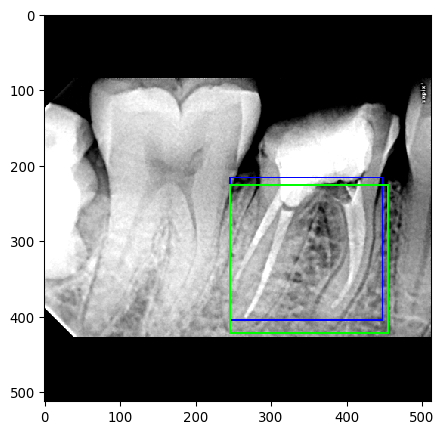

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


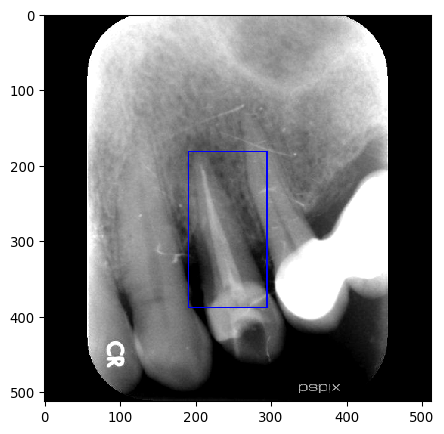

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.79637173]


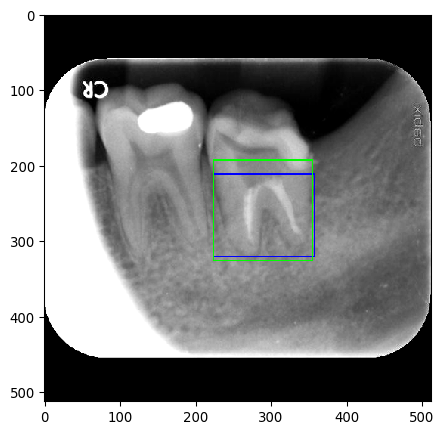

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.9292154]


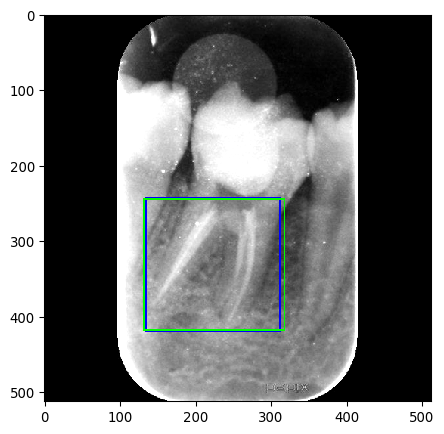

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.83881537]


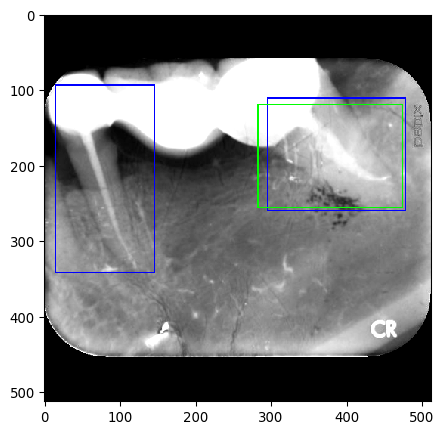

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.91099043]


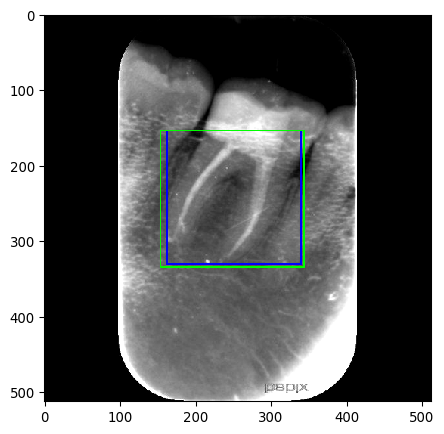

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


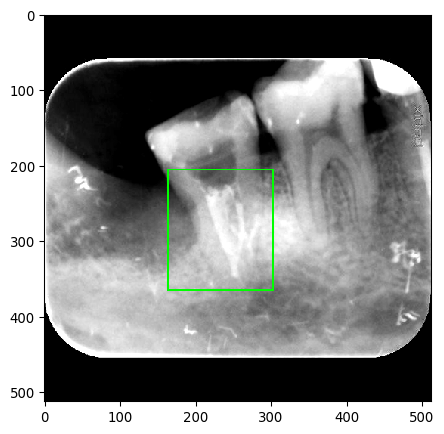

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.96950836]


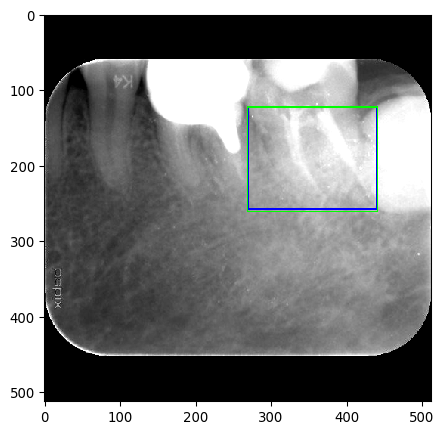

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


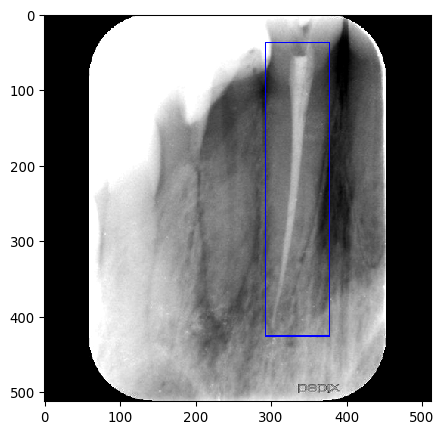

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


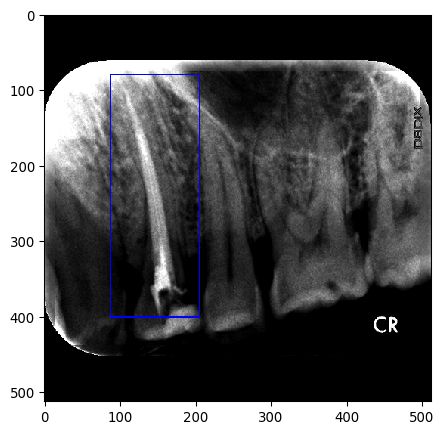

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


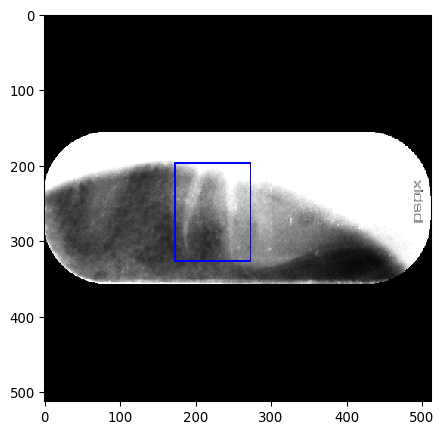

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.83636128]


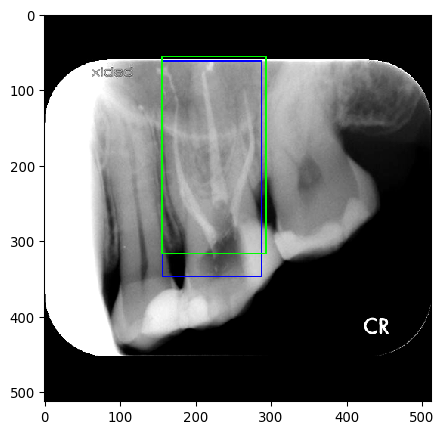

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


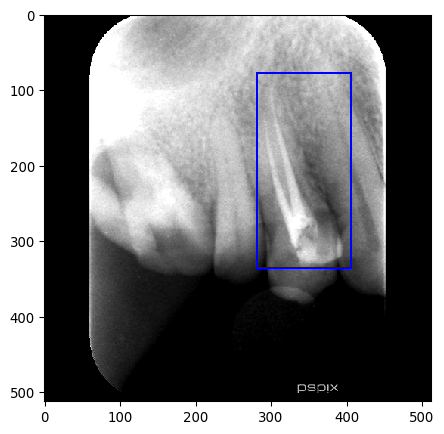

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.91620015]


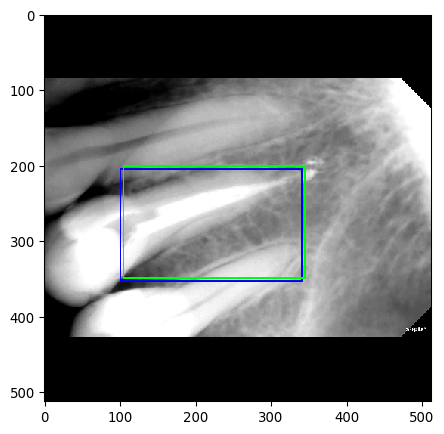

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.90908751]


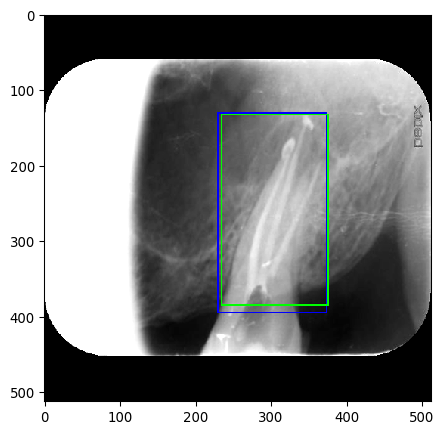

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


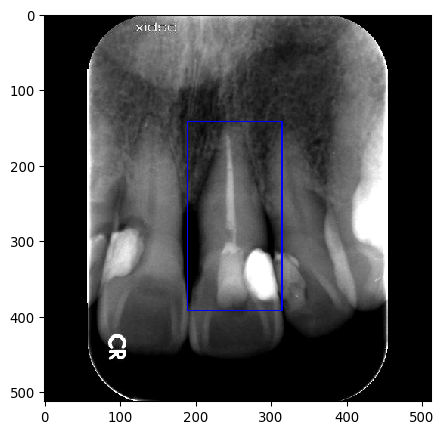

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.90598276]


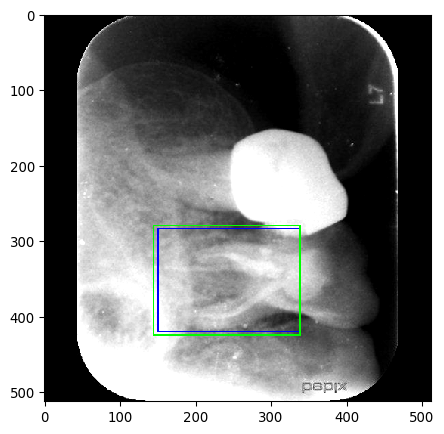

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.91607094]


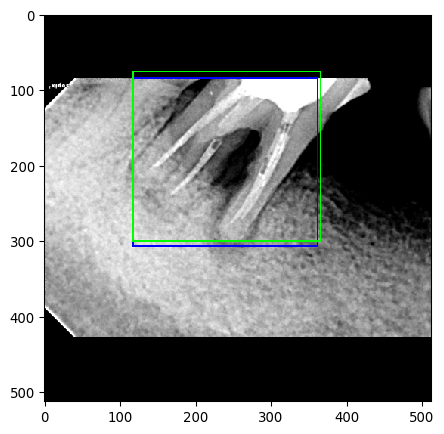

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


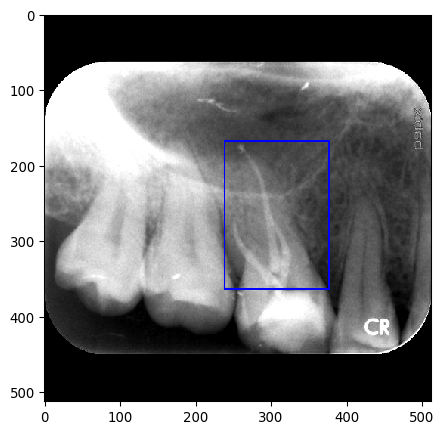

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.90684422]


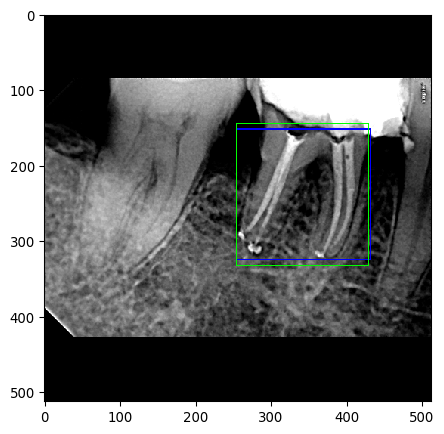

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.91672402]


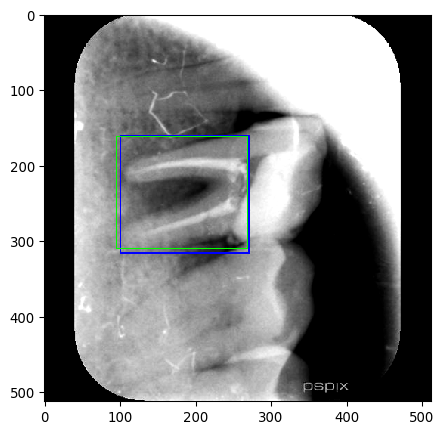

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.9177751]


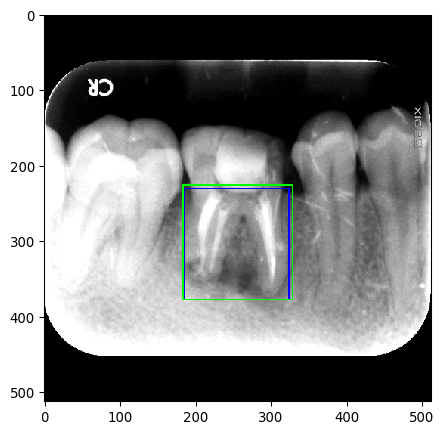

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.933258]


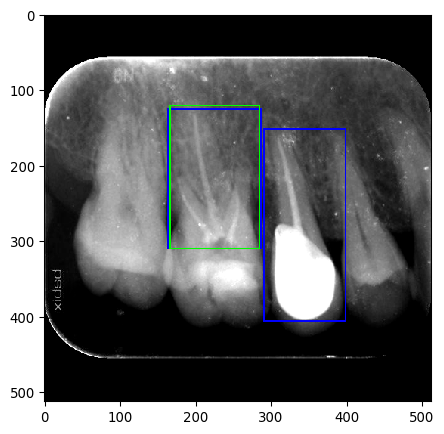

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.94735117]


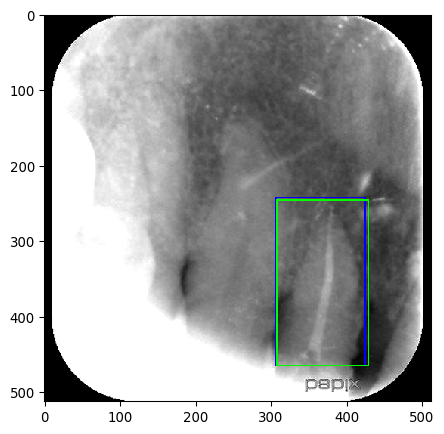

In [68]:
draw_both_box(val_set, img_pd, image_list=image_list, img_path=img_path, origin_color=[0, 0, 255], detection_color=[0, 255, 0])